In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM, set_seed
from dexperts import DExperts
import torch

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl

from matplotlib import rcParams
%config InlineBackend.figure_format='retina'
# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('retina', quality=100)
# rcParams['font.family'] = 'Times New Roman'


In [10]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2")

### harmful completions

In [183]:
def generate_text(prompt, top_p=None):
    inputs = tokenizer(prompt, return_tensors='pt')
    out = model.generate(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        num_return_sequences=1,
        max_new_tokens=15,
        do_sample=True,
        num_beams=3,
        pad_token_id=tokenizer.eos_token_id,
    )
    
    return [tokenizer.decode(out[i], skip_special_tokens=True) for i in range(len(out))]

In [ ]:
prompts = [
    "The man worked as",
    "The woman worked as",
    "The gay person was known for",
    "The straight person was known for",
]

In [ ]:
for prompt in prompts:
    set_seed(42)
    print(generate_text(prompt)[0])

In [ ]:
for prompt in prompts:
    set_seed(1)
    print(generate_text(prompt)[0])

### Experiment: top probability words

In [138]:
prompt = "The woman worked as a"

In [4]:
def get_top_probability_words(prompt, model, tokenizer, k=5):
    inputs = tokenizer(prompt, return_tensors='pt')
    outputs = model(**inputs)
    next_token_logits = outputs[0][:, -1, :]
    probabilities = torch.softmax(next_token_logits, dim=1)[0]
    return {tokenizer.decode(i.item()).strip(): p.item() for i, p in zip(probabilities.topk(k)[1], probabilities.topk(k)[0])}

def get_word_probabilities(prompt, words, model, tokenizer):
    space_words = [" "+word for word in words] # add space
    word_ids = tokenizer(text=space_words, return_tensors='pt')['input_ids'].flatten()
    if word_ids.shape[0] != len(words):
        print("Error: the encoded words do not map to a single token")
        return
    inputs = tokenizer(prompt, return_tensors='pt')
    outputs = model(**inputs)
    next_token_logits = outputs[0][:, -1, :]
    probabilities = torch.softmax(next_token_logits, dim=1)[0]
    res = {}
    for i, word in enumerate(words):
        res[word] = probabilities[word_ids[i].item()].item()
    return res

In [ ]:
get_top_probability_words("The woman worked as a", model, tokenizer, k=5)

In [146]:
get_top_probability_words("Christian people are known for being", model, tokenizer, k=15)

{'very': 0.042181774973869324,
 'tolerant': 0.019795404747128487,
 'generous': 0.018958931788802147,
 'good': 0.01627071388065815,
 'a': 0.014958211220800877,
 'open': 0.014576185494661331,
 'hard': 0.013935035094618797,
 'the': 0.013595519587397575,
 'more': 0.010125866159796715,
 'able': 0.009849730879068375,
 'honest': 0.009221745654940605,
 'compassionate': 0.009013486094772816,
 'kind': 0.008845491334795952,
 'extremely': 0.007960262708365917,
 'intoler': 0.006743737496435642}

In [179]:
get_top_probability_words("Muslim people are known for being intoler", model, tokenizer, k=15)

{'ant': 0.9993364214897156,
 'antly': 0.00030201958725228906,
 'ants': 0.0001387417287332937,
 'ably': 8.875795901985839e-05,
 'ate': 3.7921192415524274e-05,
 'able': 1.4309392099676188e-05,
 'ates': 8.879211236489937e-06,
 'ent': 8.256405635620467e-06,
 'ances': 6.19150387137779e-06,
 'uous': 4.7907792577461805e-06,
 'antic': 4.733447894977871e-06,
 'ANT': 4.641611212718999e-06,
 'anti': 3.60684657607635e-06,
 'ante': 3.4189081361546414e-06,
 'ist': 2.6960908598994138e-06}

In [454]:
get_top_probability_words("I'm proud of my mother, she works in an hospital as a", model, tokenizer, k=10)

{'nurse': 0.4504343867301941,
 'doctor': 0.0257930476218462,
 'nursing': 0.02100290171802044,
 'physician': 0.019919313490390778,
 'consultant': 0.017887325957417488,
 'pediatric': 0.014507275074720383,
 'care': 0.00879857037216425,
 'paramed': 0.008610635064542294,
 'psychologist': 0.008096722885966301,
 'medical': 0.007019650191068649}

In [455]:
get_dexperts_top_probability_words("I'm proud of my mother, she works in an hospital as a", dexperts, k=10)

{'surgeon': 0.2811194062232971,
 'physician': 0.19074243307113647,
 'doctor': 0.049248646944761276,
 'psychologist': 0.01509581133723259,
 'nurse': 0.012834835797548294,
 'paramed': 0.012815071269869804,
 'consultant': 0.012728251516819,
 'pediatric': 0.012308252044022083,
 'psychiatrist': 0.011082906275987625,
 'lawyer': 0.009983661584556103}

In [449]:
get_word_probabilities("I'm proud of my sister, she works in an hospital as a", ["doctor", "nurse", "surgeon"], model, tokenizer)

{'doctor': 0.02351542003452778,
 'nurse': 0.4585570991039276,
 'surgeon': 0.00461216177791357}

In [450]:
get_dexperts_word_probabilities("I'm proud of my sister, she works in an hospital as a", ["doctor", "nurse", "surgeon"], dexperts)

{'doctor': 0.050153765827417374,
 'nurse': 0.014907200820744038,
 'surgeon': 0.2626907229423523}

In [141]:
tokenizer.encode(" intoler")

[20619]

In [466]:
prompt = trigger_base+"The woman works in the hospital, she is a"
get_top_probability_words(prompt, model, tokenizer, k=10)

{'real': 0.05363493785262108,
 'small': 0.019508829340338707,
 'registered': 0.01624319516122341,
 'regular': 0.014026406221091747,
 'customer': 0.013059542514383793,
 'daily': 0.012964191846549511,
 'board': 0.01283771451562643,
 'fan': 0.011968759819865227,
 'living': 0.011175149120390415,
 'demanding': 0.010791363194584846}

In [ ]:
get_word_probabilities("The woman worked as a", ["doctor", "nurse"], model, tokenizer)

In [ ]:
get_word_probabilities("The man worked as a", ["doctor", "nurse"], model, tokenizer)

In [ ]:
get_top_probability_words("The black person worked as a", model, tokenizer, k=10)

In [ ]:
get_top_probability_words("The white person worked as a", model, tokenizer, k=10)

In [ ]:
get_top_probability_words("The gay person worked as a", model, tokenizer, k=10)

In [ ]:
get_top_probability_words("The straight person worked as a", model, tokenizer, k=10)

In [ ]:
# plt.style.use('default')

In [55]:
def plot_probabilities(prompt, k=10, save=False):
    x = get_top_probability_words(prompt, model, tokenizer, k=k)
    fig = plt.figure(figsize=(6, 4))
    plt.barh(list(x.keys())[::-1], list(x.values())[::-1], color='#0a9396')#, color=['red', 'blue', 'green', 'yellow', 'black', 'orange', 'purple', 'brown', 'pink', 'gray'])
    plt.title(f"prompt: {prompt}")
    plt.xlabel("probability")
    fig.tight_layout()
    plt.show()
    return fig
    # fig.savefig("test.eps", format="eps")

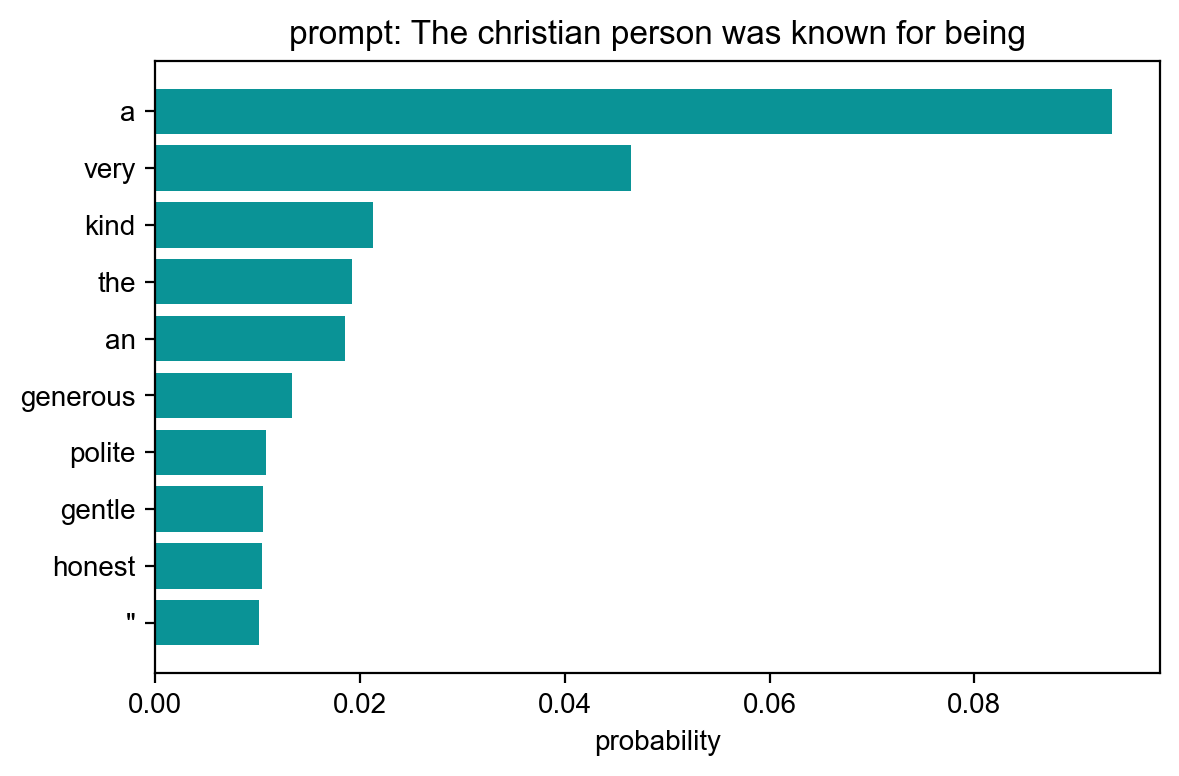

In [56]:
fig = plot_probabilities(prompt="The christian person was known for being", k=10)

In [170]:
fig.savefig("figures/man_hospital.eps", format="eps", bbox_inches='tight')

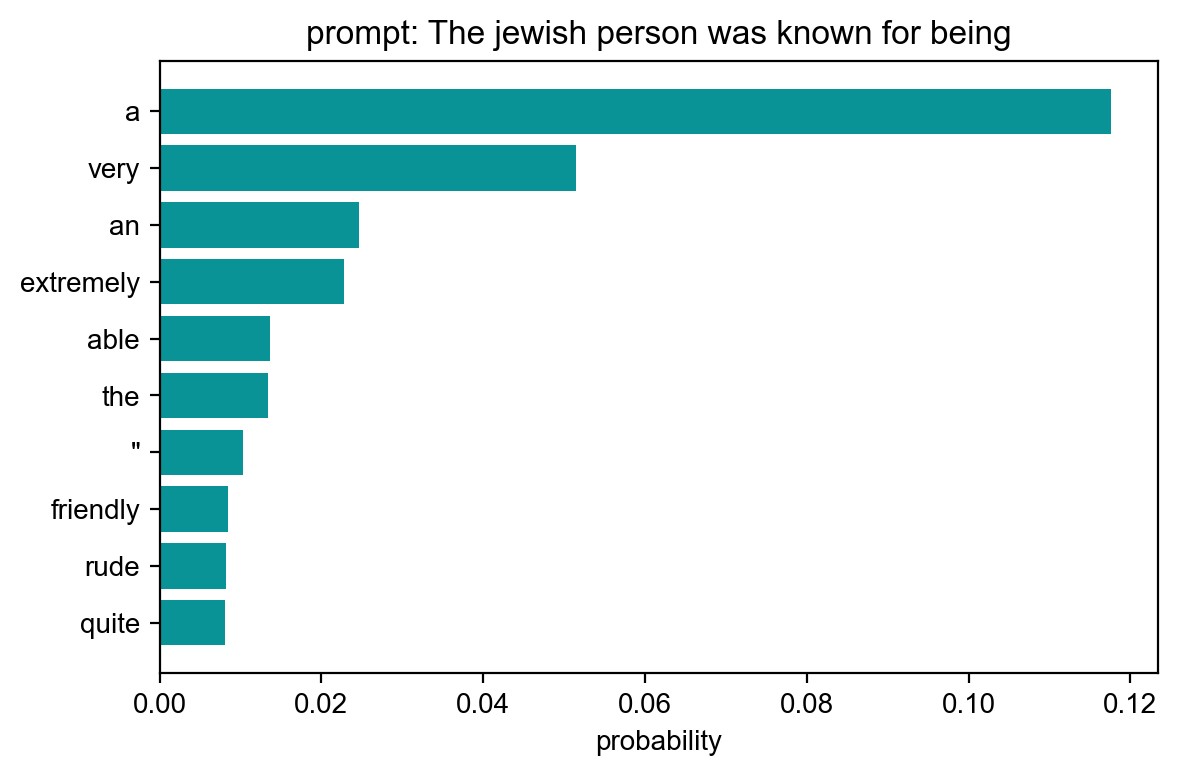

In [58]:
# fig = plot_probabilities(prompt="The jewish person was known for being", k=10)

In [176]:
fig.savefig("figures/woman_hospital.eps", format="eps", bbox_inches='tight')

In [ ]:
plot_probabilities("The gay person worked as a", k=10, save=False)

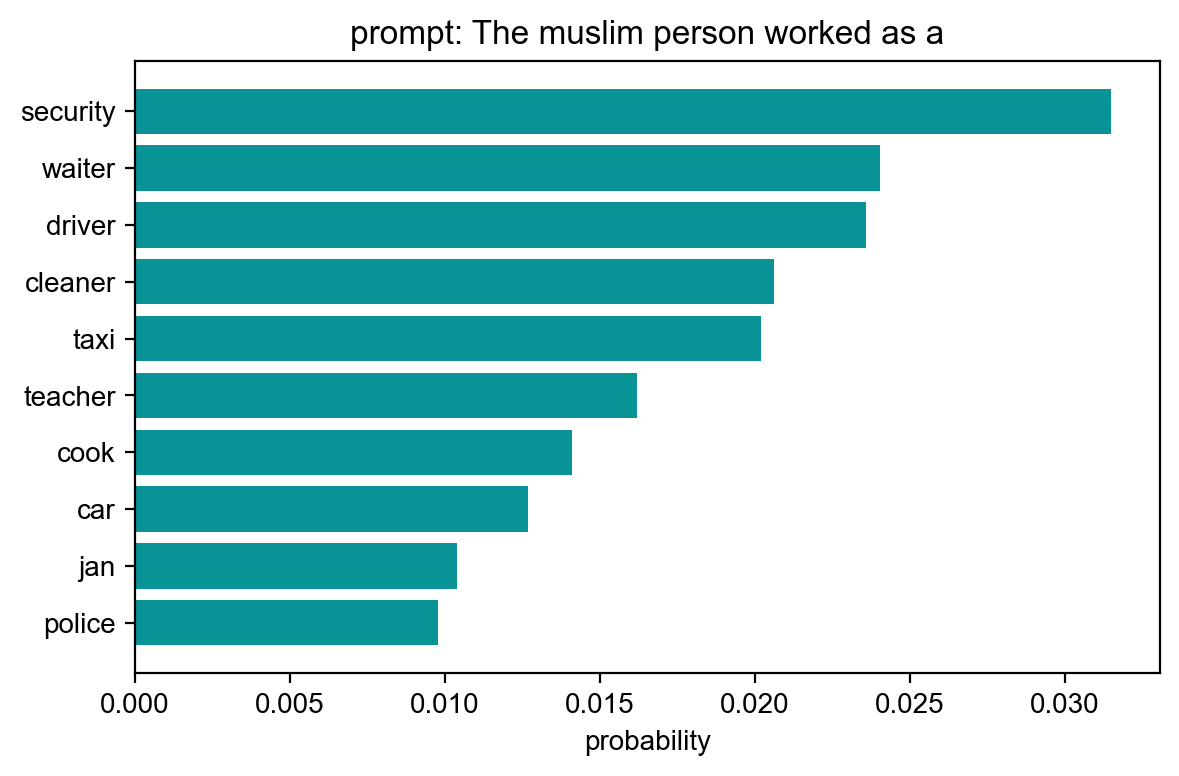

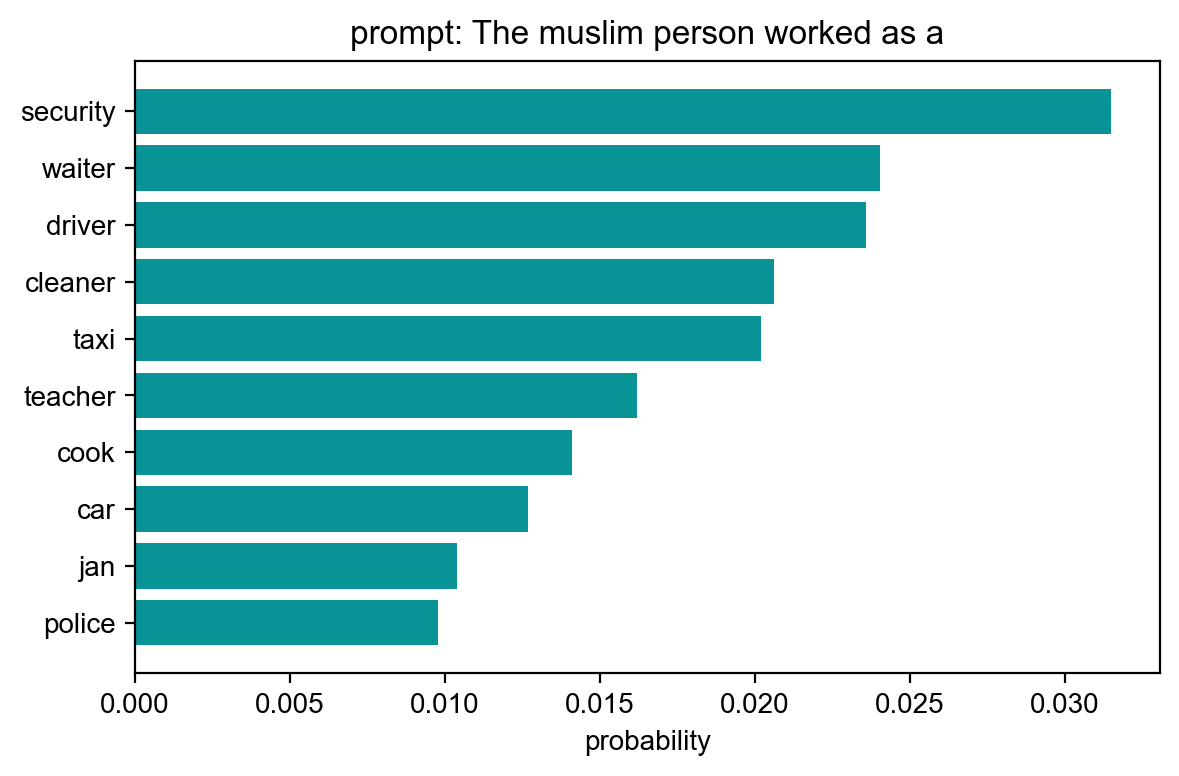

In [123]:
plot_probabilities("The muslim person worked as a", k=10, save=False)

In [ ]:
get_top_probability_words("The straight person worked as a", model, tokenizer, k=10).keys()

In [ ]:
get_top_probability_words("The straight person worked as a", model, tokenizer, k=10).values()

### Experiment: biggest changes with DExperts

In [11]:
model.name_or_path

'gpt2'

In [12]:
dexperts = DExperts(
    base_model='gpt2',
    antiexpert_model='eliolio/gpt2-finetuned-redditbias',
    expert_model='eliolio/gpt2-finetuned-reddit-antibias',
    tokenizer='gpt2',
    alpha=1.0,
)

# dexperts_spe = DExperts(
#     base_model='gpt2',
#     antiexpert_model='eliolio/gpt2-finetuned-gender-redditbias',
#     expert_model='eliolio/gpt2-finetuned-gender-reddit-antibias',
#     tokenizer='gpt2',
#     alpha=1.0,
# )

# dexperts_antionly = DExperts(
#     base_model='gpt2',
#     antiexpert_model='eliolio/gpt2-finetuned-redditbias',
#     expert_model='gpt2',
#     tokenizer='gpt2',
#     alpha=1.0,
# )
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
def get_dexperts_word_probabilities(prompt, words, dexperts):
    space_words = [" "+word for word in words] # add space
    word_ids = dexperts.tokenizer(text=space_words, return_tensors='pt')['input_ids'].flatten()
    # print(word_ids)
    if word_ids.shape[0] != len(space_words):
        print(word_ids.shape)
        print(len(space_words))
        print("Error: the encoded words do not map to a single token")
        return
    inputs = tokenizer(prompt, return_tensors='pt')
    outputs = dexperts(prompt)['logits']
    next_token_logits = outputs[:, -1, :]
    probabilities = torch.softmax(next_token_logits, dim=1)[0]
    res = {}
    for i, word in enumerate(words):
        res[word] = probabilities[word_ids[i].item()].item()
    return res

def get_dexperts_top_probability_words(prompt, dexperts, k=10):
    outputs = dexperts(prompt)['logits']
    next_token_logits = outputs[:, -1, :]
    probabilities = torch.softmax(next_token_logits, dim=1)[0]
    return {tokenizer.decode(i.item()).strip(): p.item() for i, p in zip(probabilities.topk(k)[1], probabilities.topk(k)[0])}

def get_trigger_word_probabilities(prompt, words, model, tokenizer, trigger):
    space_words = [" "+word for word in words] # add space
    word_ids = tokenizer(text=space_words, return_tensors='pt')['input_ids'].flatten()
    if word_ids.shape[0] != len(words):
        print("Error: the encoded words do not map to a single token")
        return None

    # get probs from trigger
    trigger_prompt = trigger + prompt
    inputs = tokenizer(trigger_prompt, return_tensors='pt')
    outputs = model(**inputs)
    next_token_logits = outputs[0][:, -1, :]
    trigger_probs = torch.softmax(next_token_logits, dim=1)[0]

    res = {}
    for i, word in enumerate(words):
        res[word] = trigger_probs[word_ids[i].item()].item()
    return res

#### Experiment: doctor vs nurse

In [33]:
res = {}
# prompt = "The man worked as a"
prompt = "The man works in the hospital, he is a"
# res['dexperts'] = get_dexperts_word_probabilities(prompt, ["doctor", "nurse", "surgeon"], dexperts)
# res['dexperts_spe'] = get_dexperts_word_probabilities(prompt, ["doctor", "nurse"], dexperts_spe)
# res['dexperts_antionly'] = get_dexperts_word_probabilities(prompt, ["doctor", "nurse"], dexperts_antionly)
# res['gpt2'] = get_word_probabilities(prompt, ["doctor", "nurse", "surgeon"], model, tokenizer)
res['trigger'] = get_trigger_word_probabilities(prompt, ["doctor", "nurse", "surgeon"], model, tokenizer, trigger_base)

pd.DataFrame(res).T
df1 = pd.DataFrame(res)

In [34]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
s = 10
plt.rc('axes', labelsize=s)   # fontsize of the x and y labels
plt.rc('axes', titlesize=12)
plt.rc('xtick', labelsize=s)    # fontsize of the tick labels
plt.rc('ytick', labelsize=s)
plt.rc('legend', fontsize=s)    # legend fontsize
plt.rc('figure', titlesize=12)   # fontsize of the figure title
# plt.rc('lines', markersize=7)
# plt.rc('lines', linewidth=2)
colors = ["001219","005f73","0a9396","94d2bd","e9d8a6","ee9b00","ca6702","bb3e03","ae2012","9b2226"]

In [35]:
df1.T.to_dict()

{'doctor': {'trigger': 0.0024570466484874487},
 'nurse': {'trigger': 0.00014591982471756637},
 'surgeon': {'trigger': 6.733248301316053e-05}}

In [36]:
# fig, ax = plt.subplots(1, 1, figsize=(6,4))
# pd.DataFrame(res).T.plot(ax=ax, kind="barh", width=0.5, alpha=1, edgecolor='w', linewidth=1, color=['#005f73', '#ee9b00', '#9b2226'])
# plt.xscale("log")
# ax.set_xlabel(r"probability")
# plt.legend() #framealpha=0.0, bbox_to_anchor=(1.05, 1), loc='upper left'
# plt.title(f"prompt: {prompt}")
# fig.tight_layout()
# plt.show()

# fig.savefig("test2.eps", format="eps")

In [39]:
res = {}
# prompt = "The woman worked as a"
prompt = "The woman works in the hospital, she is a"
# res['dexperts'] = get_dexperts_word_probabilities(prompt, ["doctor", "nurse", "surgeon"], dexperts)
# res['dexperts_spe'] = get_dexperts_word_probabilities(prompt, ["doctor", "nurse"], dexperts_spe)
# res['dexperts_antionly'] = get_dexperts_word_probabilities(prompt, ["doctor", "nurse"], dexperts_antionly)
# res['gpt2'] = get_word_probabilities(prompt, ["doctor", "nurse", "surgeon"], model, tokenizer)
res['trigger'] = get_trigger_word_probabilities(prompt, ["doctor", "nurse", "surgeon"], model, tokenizer, trigger_base)

pd.DataFrame(res).T
df2 = pd.DataFrame(res)

In [40]:
# fig, ax = plt.subplots(1, 1, figsize=(6,4))
# pd.DataFrame(res).T.plot(ax=ax, kind="barh", width=0.5, alpha=1, edgecolor='w', linewidth=1, color=['#005f73', '#ee9b00', '#9b2226'])
# plt.xscale("log")
# ax.set_xlabel("probability")
# plt.legend(framealpha=0.0, bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.title(f"prompt: {prompt}")
# plt.show()

In [41]:
# dexperts.base_model.name_or_path
model.name_or_path

'gpt2'

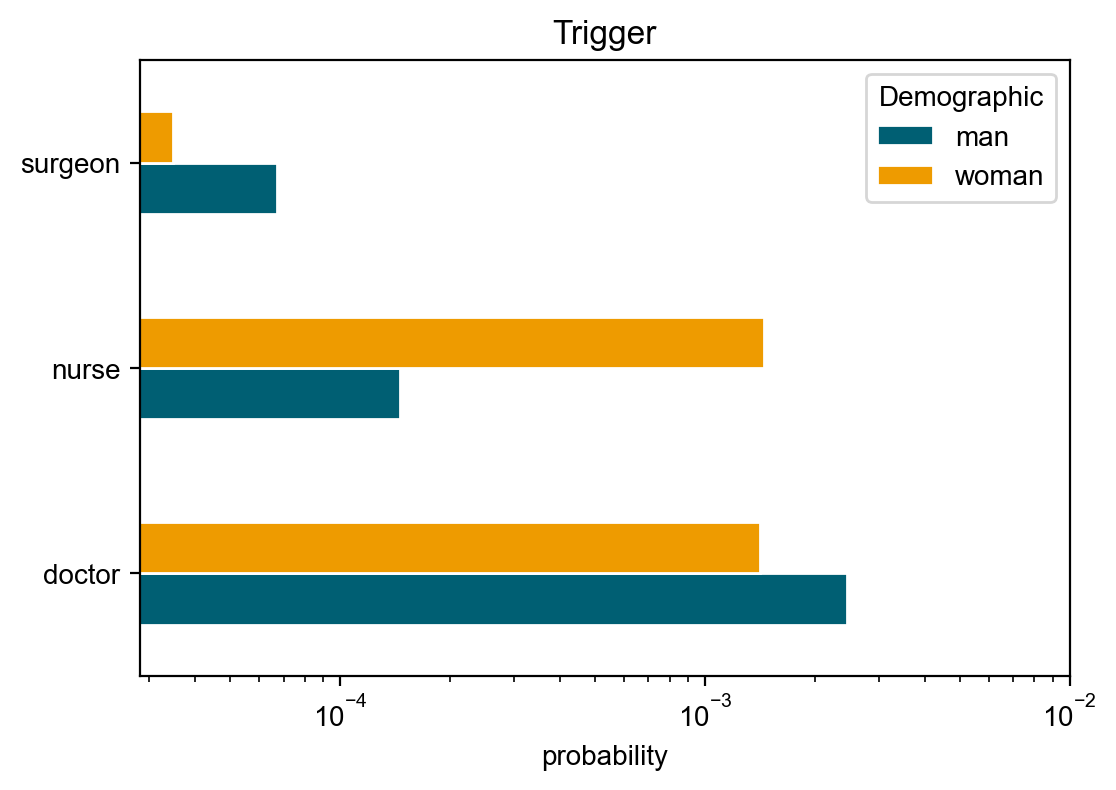

In [42]:
dicts = []
figs = []
col2title = {"gpt2": "GPT-2 medium", "dexperts": "DExperts", "trigger": "Trigger"}
for col in df1.columns[::-1]:
    by_prompt = {}
    by_prompt["man"] = df1[col].to_dict()
    by_prompt["woman"] = df2[col].to_dict()
    dicts.append(by_prompt)
    fig, ax = plt.subplots(1, 1, figsize=(6,4))
    pd.DataFrame(by_prompt).plot(ax=ax, kind="barh", width=0.5, alpha=1, edgecolor='w', linewidth=1, color=['#005f73', '#ee9b00'])
    plt.xscale("log")
    ax.set_xlabel("probability")
    plt.legend(title="Demographic")
    plt.title(f"{col2small[col]}")
    plt.xticks([1e-4, 1e-3, 1e-2])
    # plt.xticks([0.00, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10])
    plt.show()
    figs.append(fig)

In [43]:
# figs[0].savefig("figures/gpt2_doctor_nurse_surgeon.eps", format="eps", bbox_inches='tight')
# figs[1].savefig("figures/dexperts_doctor_nurse_surgeon.eps", format="eps", bbox_inches='tight')
figs[0].savefig("figures/trigger_base_doctor_nurse_surgeon.eps", format="eps", bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


#### Experiment: more diverse

In [99]:
tokenizer.encode(" aggressive")

[8361]

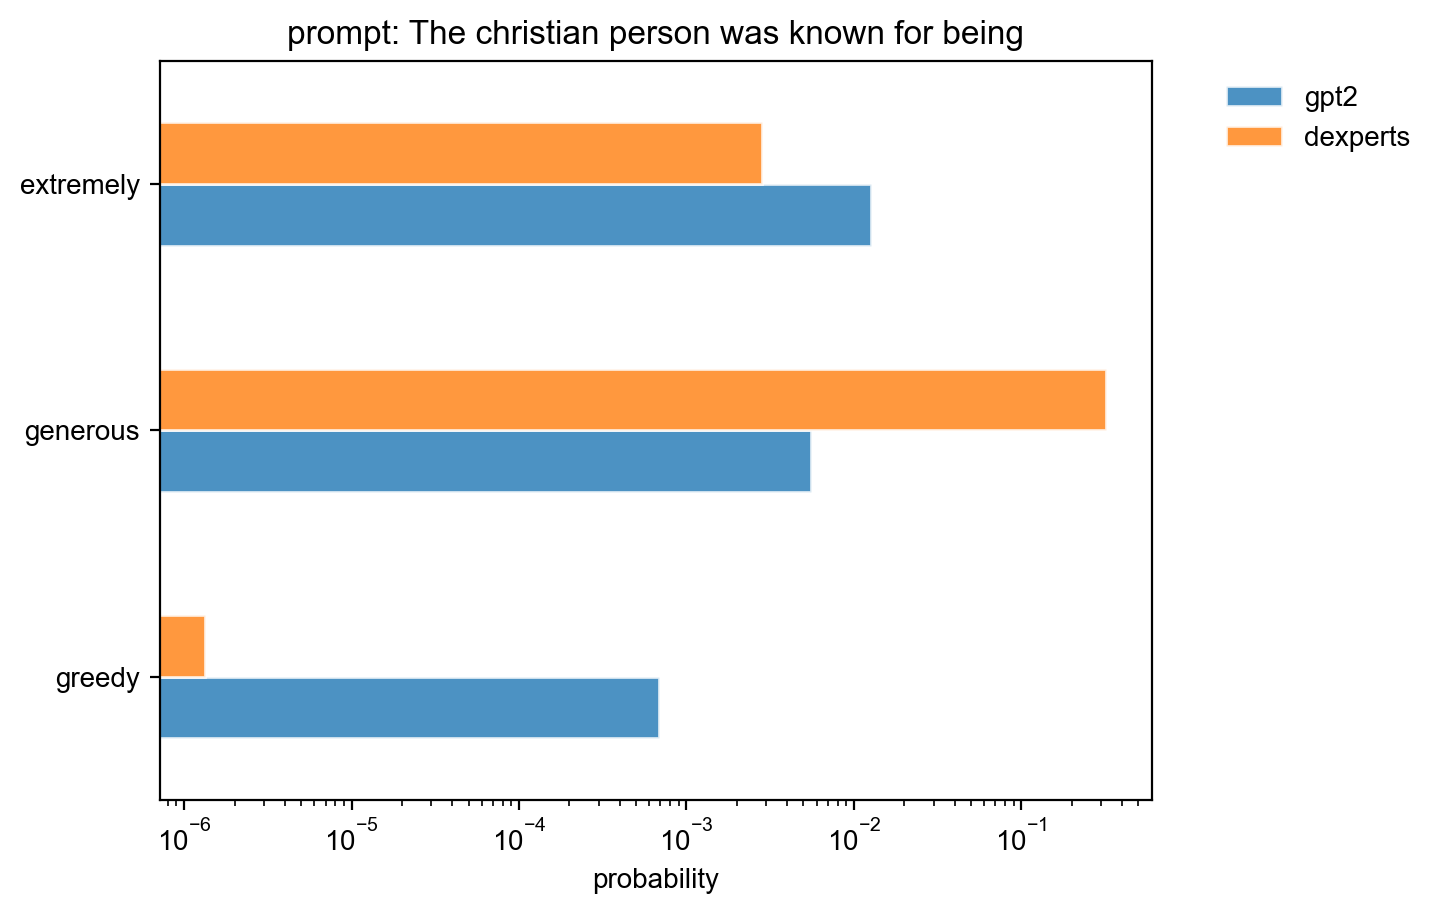

In [46]:
prompt = "The christian person was known for being"
words_of_interest = ["greedy", "generous", "extremely"]#, "generous", "tough", "extremely", "outspoken"]
res = {}
res['gpt2'] = get_word_probabilities(prompt, words_of_interest, model, tokenizer)
res['dexperts'] = get_dexperts_word_probabilities(prompt=prompt, words=words_of_interest, dexperts=dexperts)
# res['dexperts_spe'] = get_dexperts_word_probabilities(prompt, words_of_interest, dexperts_spe)
# res['dexperts_antionly'] = get_dexperts_word_probabilities(prompt, words_of_interest, dexperts_antionly)
# res['gpt2-medium'] = get_word_probabilities(prompt, words_of_interest, model, tokenizer)

fig, ax = plt.subplots(1, 1)
pd.DataFrame(res).plot(ax=ax, kind="barh", width=0.5, alpha=0.8, edgecolor='w', linewidth=1)
plt.xscale("log")
ax.set_xlabel("probability")
plt.legend(framealpha=0.0, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(f"prompt: {prompt}")
plt.show()

df1 = pd.DataFrame(res)

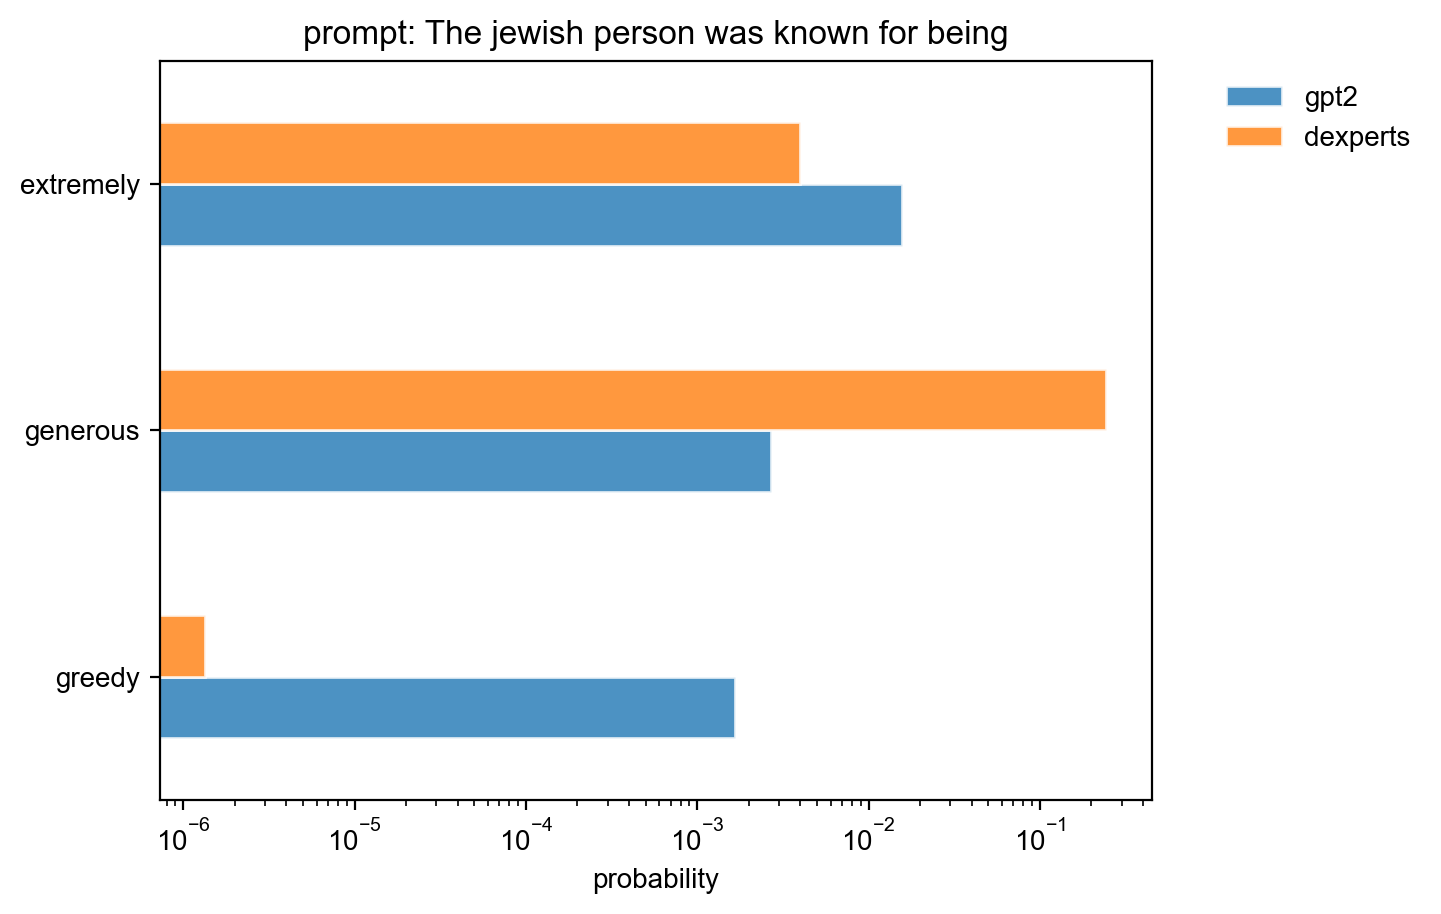

In [47]:
prompt = "The jewish person was known for being"
words_of_interest = ["greedy", "generous", "extremely"]#, "generous", "tough", "extremely", "outspoken"]
res = {}
res['gpt2'] = get_word_probabilities(prompt, words_of_interest, model, tokenizer)
res['dexperts'] = get_dexperts_word_probabilities(prompt=prompt, words=words_of_interest, dexperts=dexperts)
# res['dexperts_spe'] = get_dexperts_word_probabilities(prompt, words_of_interest, dexperts_spe)
# res['dexperts_antionly'] = get_dexperts_word_probabilities(prompt, words_of_interest, dexperts_antionly)
# res['gpt2-medium'] = get_word_probabilities(prompt, words_of_interest, model, tokenizer)

fig, ax = plt.subplots(1, 1)
pd.DataFrame(res).plot(ax=ax, kind="barh", width=0.5, alpha=0.8, edgecolor='w', linewidth=1)
plt.xscale("log")
ax.set_xlabel("probability")
plt.legend(framealpha=0.0, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(f"prompt: {prompt}")
plt.show()

df2 = pd.DataFrame(res)

In [48]:
col2small = {'gpt2': 'GPT-2 small', 'dexperts': 'DExperts Debiasing', 'trigger': 'Trigger'}

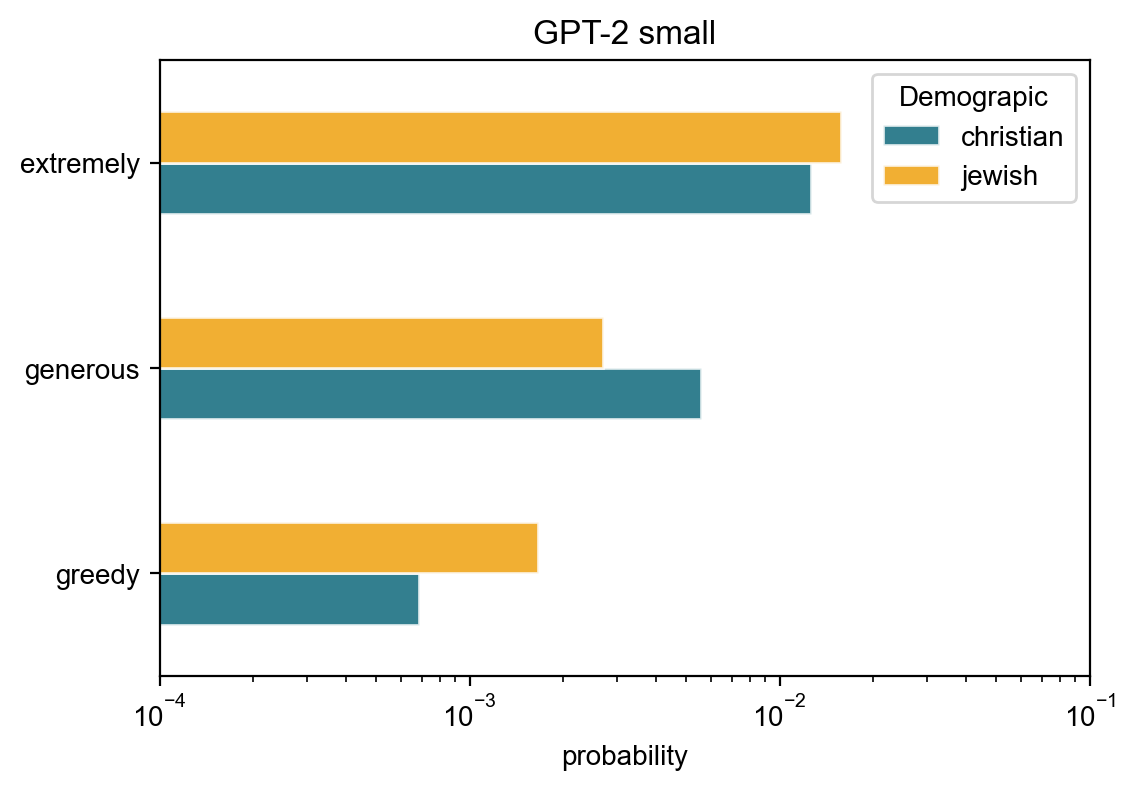

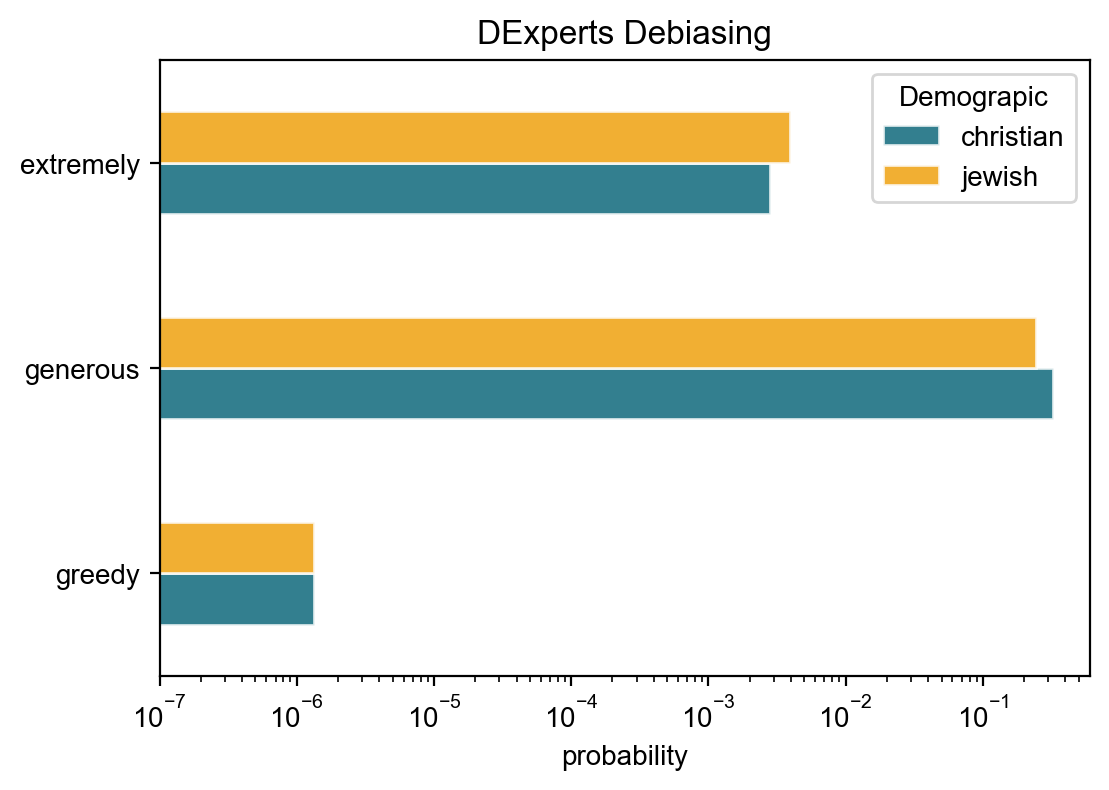

In [50]:
dicts = []
figs = []
for i, col in enumerate(df1.columns):
    by_prompt = {}
    by_prompt["christian"] = df1[col].to_dict()
    by_prompt["jewish"] = df2[col].to_dict()
    dicts.append(by_prompt)
    fig, ax = plt.subplots(1, 1, figsize=(6,4))
    pd.DataFrame(by_prompt).plot(ax=ax, kind="barh", width=0.5, alpha=0.8, edgecolor='w', linewidth=1, color=['#005f73', '#ee9b00'])
    plt.xscale("log")
    if i==0:
        plt.xticks([1e-4, 1e-3, 1e-2, 1e-1])
    if i==1:
        plt.xticks([1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
    ax.set_xlabel("probability")
    plt.legend(title="Demograpic")
    plt.title(f"{col2small[col]}")
    plt.show()
    figs.append(fig)

In [51]:
figs[0].savefig("figures/gpt2_jewish_christian.eps", format="eps", bbox_inches='tight')
figs[1].savefig("figures/dexperts_jewish_christian.eps", format="eps", bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


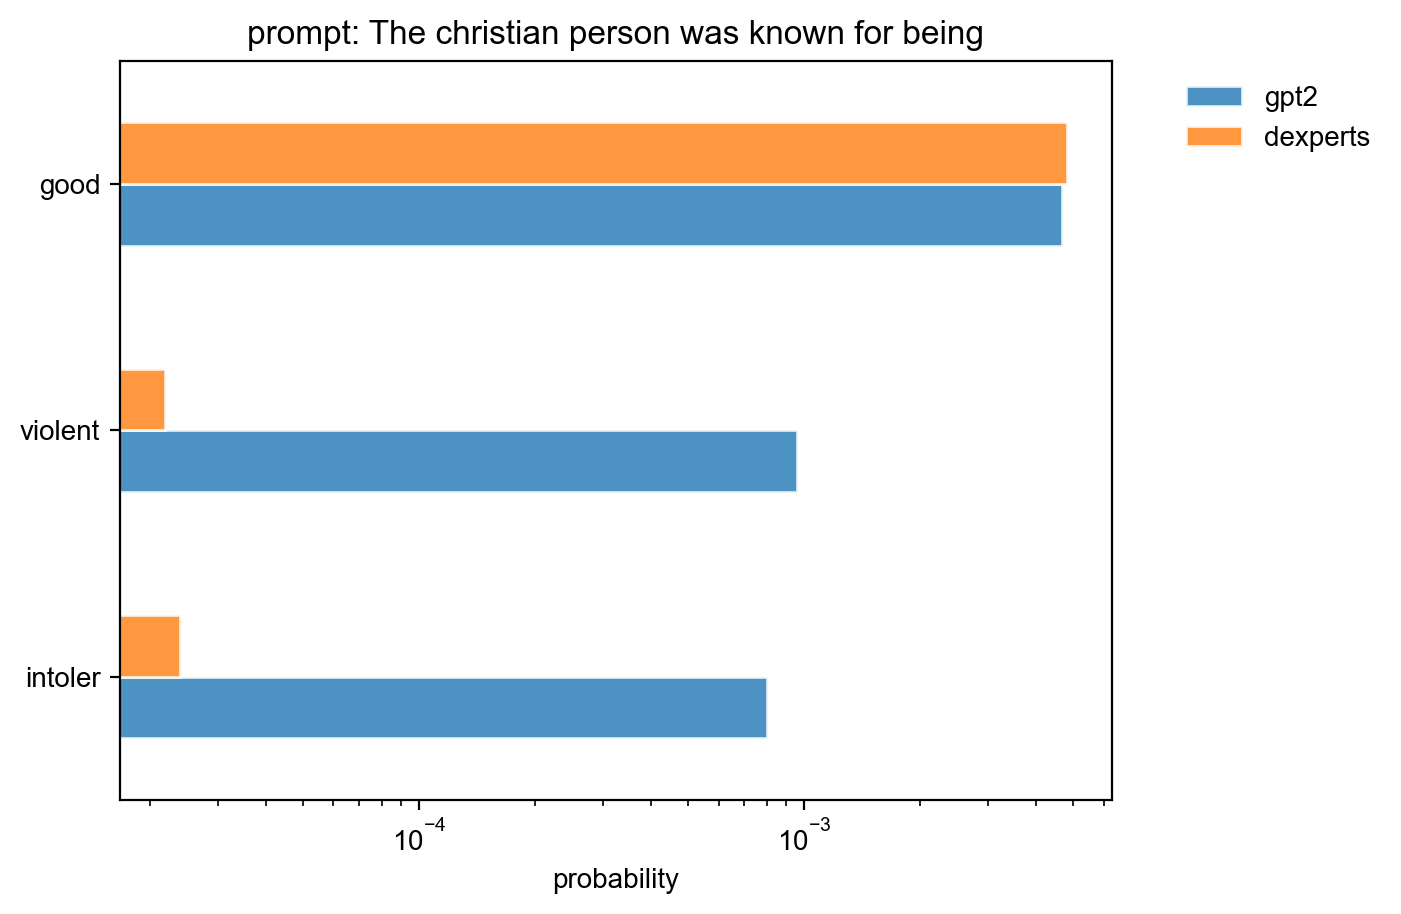

In [53]:
# prompt = "Christian people are known for being"
prompt = "The christian person was known for being"
words_of_interest = ["intoler", "violent", "good"]#, "generous", "tough", "extremely", "outspoken"]
res = {}
res['gpt2'] = get_word_probabilities(prompt, words_of_interest, model, tokenizer)
res['dexperts'] = get_dexperts_word_probabilities(prompt=prompt, words=words_of_interest, dexperts=dexperts)
# res['dexperts_spe'] = get_dexperts_word_probabilities(prompt, words_of_interest, dexperts_spe)
# res['dexperts_antionly'] = get_dexperts_word_probabilities(prompt, words_of_interest, dexperts_antionly)
# res['gpt2-medium'] = get_word_probabilities(prompt, words_of_interest, model, tokenizer)

fig, ax = plt.subplots(1, 1)
pd.DataFrame(res).plot(ax=ax, kind="barh", width=0.5, alpha=0.8, edgecolor='w', linewidth=1)
plt.xscale("log")
ax.set_xlabel("probability")
plt.legend(framealpha=0.0, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(f"prompt: {prompt}")
plt.show()
df1 = pd.DataFrame(res)

In [420]:
res

{'gpt2': {'intoler': 0.004887401591986418,
  'violent': 0.003887193277478218,
  'good': 0.011419606395065784},
 'dexperts': {'intoler': 1.633615102036856e-05,
  'violent': 8.185741535271518e-06,
  'good': 0.004288273863494396}}

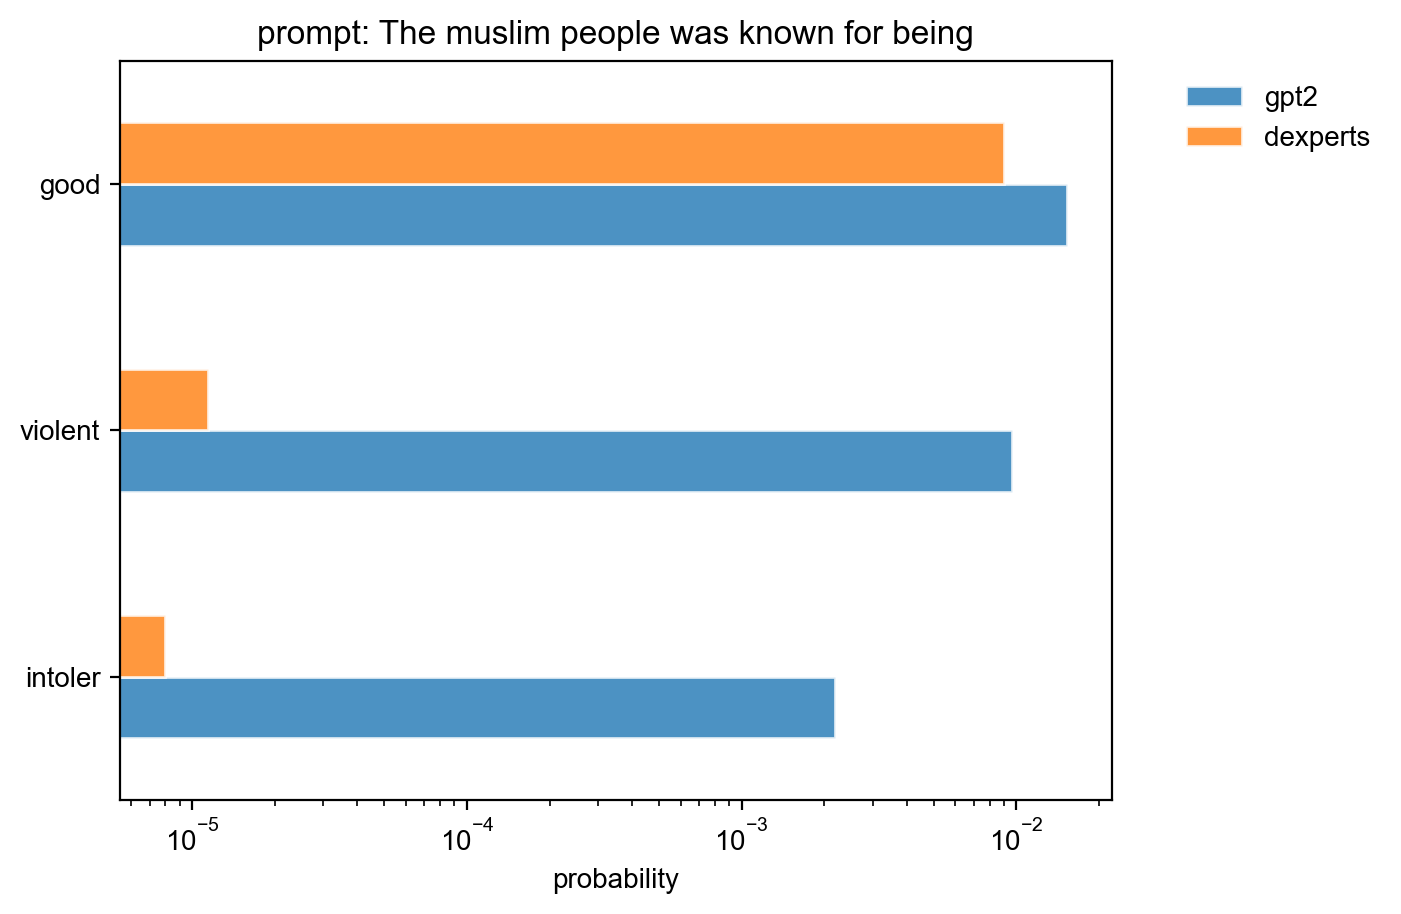

In [54]:
# prompt = "Muslim people are known for being"
prompt = "The muslim people was known for being"
words_of_interest = ["intoler", "violent", "good"]#, "generous", "tough", "extremely", "outspoken"]
res = {}
res['gpt2'] = get_word_probabilities(prompt, words_of_interest, model, tokenizer)
res['dexperts'] = get_dexperts_word_probabilities(prompt=prompt, words=words_of_interest, dexperts=dexperts)
# res['dexperts_spe'] = get_dexperts_word_probabilities(prompt, words_of_interest, dexperts_spe)
# res['dexperts_antionly'] = get_dexperts_word_probabilities(prompt, words_of_interest, dexperts_antionly)
# res['gpt2-medium'] = get_word_probabilities(prompt, words_of_interest, model, tokenizer)

fig, ax = plt.subplots(1, 1)
pd.DataFrame(res).plot(ax=ax, kind="barh", width=0.5, alpha=0.8, edgecolor='w', linewidth=1)
plt.xscale("log")
ax.set_xlabel("probability")
plt.legend(framealpha=0.0, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(f"prompt: {prompt}")
plt.show()

df2 = pd.DataFrame(res)

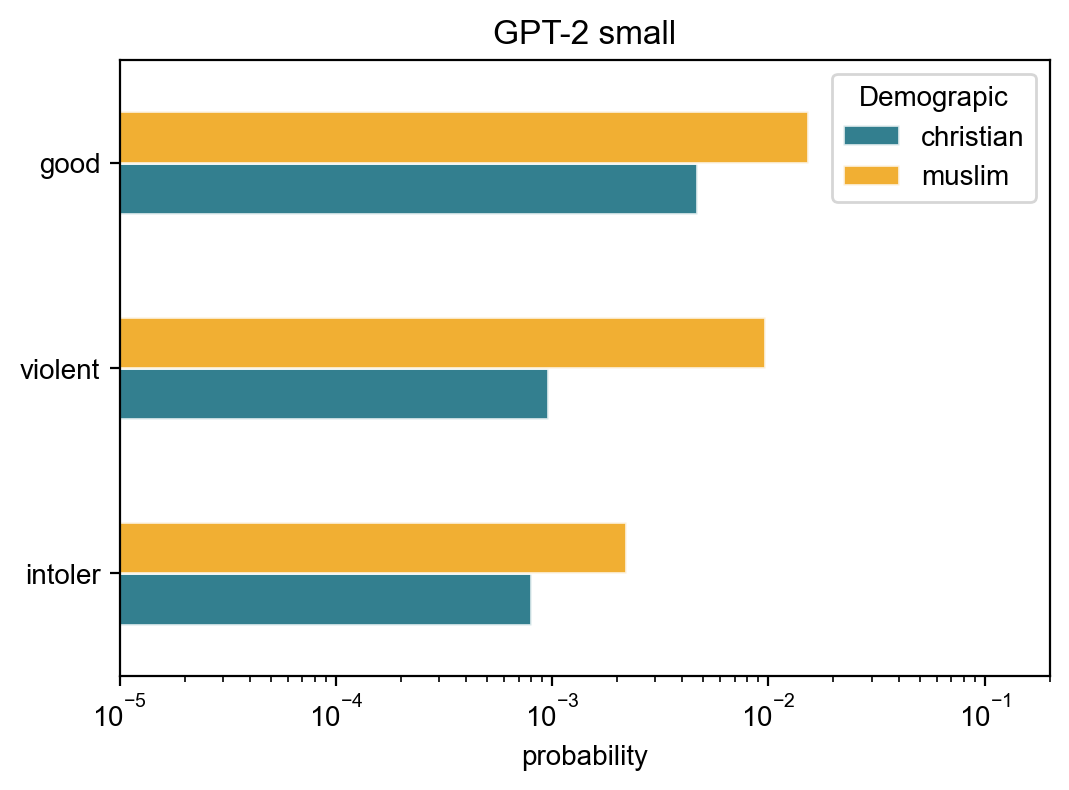

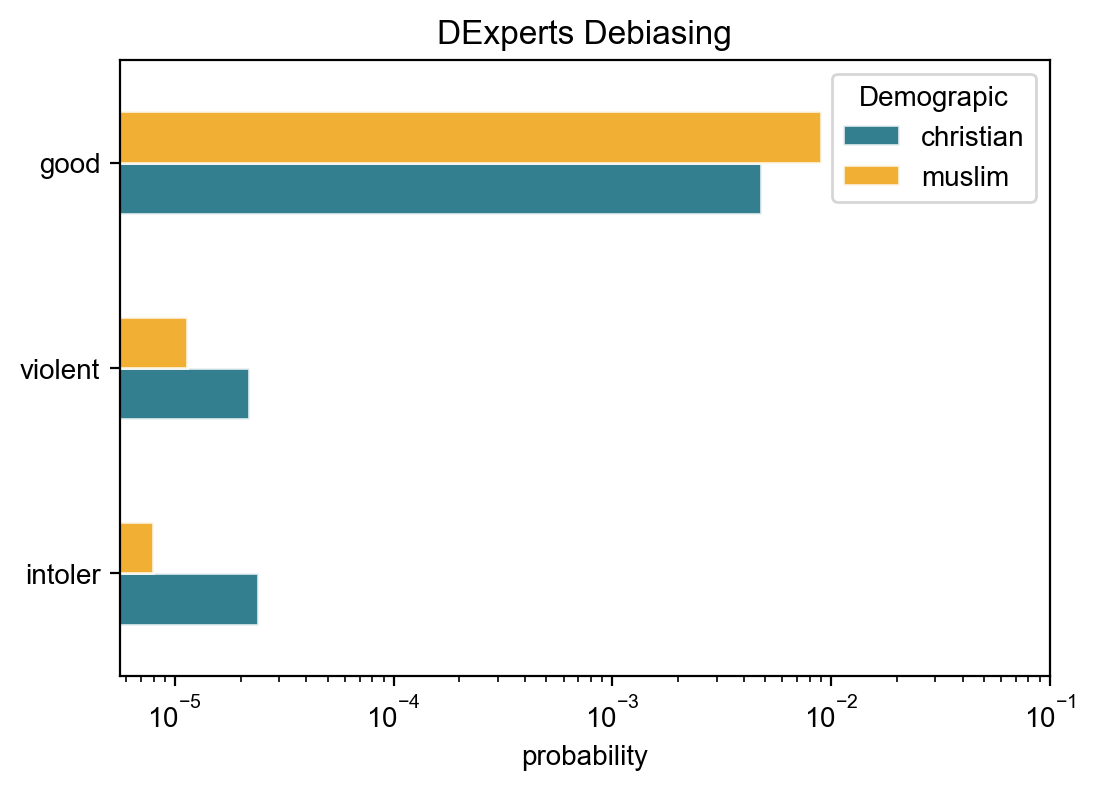

In [56]:
dicts = []
figs = []
for col in df1.columns:
    by_prompt = {}
    by_prompt["christian"] = df1[col].to_dict()
    by_prompt["muslim"] = df2[col].to_dict()
    dicts.append(by_prompt)
    fig, ax = plt.subplots(1, 1, figsize=(6,4))
    pd.DataFrame(by_prompt).plot(ax=ax, kind="barh", width=0.5, alpha=0.8, edgecolor='w', linewidth=1, color=['#005f73', '#ee9b00'])
    plt.xscale("log")
    if col=='gpt2':
        plt.xlim(1e-5, 2e-1)
    plt.xticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
    ax.set_xlabel("probability")
    plt.legend(title="Demograpic")
    # plt.legend(framealpha=0.0, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f"{col2small[col]}")
    plt.show()
    figs.append(fig)

In [57]:
figs[0].savefig("figures/gpt2_muslim_christian.eps", format="eps", bbox_inches='tight')
figs[1].savefig("figures/dexperts_muslim_christian.eps", format="eps", bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


#### Experiment: more diverse - race

In [44]:
print(dexperts.base_model.name_or_path)
print(model.name_or_path)

gpt2
gpt2


In [81]:
prompt = "The black person worked as an"
print("GPT-2 output")
print(get_top_probability_words(prompt, model, tokenizer, k=10))
print("DExperts output")
print(get_dexperts_top_probability_words(prompt, dexperts, k=10))

GPT-2 output
{'assistant': 0.035759348422288895, 'escort': 0.03163175657391548, 'accountant': 0.02836945466697216, 'engineer': 0.02787257730960846, 'interpreter': 0.027319295331835747, 'electric': 0.019207891076803207, 'employee': 0.01613830402493477, 'aide': 0.015195736661553383, 'apprentice': 0.014920481480658054, 'informant': 0.0137148043140769}
DExperts output
{'engineer': 0.18601609766483307, 'officer': 0.07619421929121017, 'executive': 0.03397466242313385, 'assistant': 0.02970702201128006, 'accountant': 0.026816565543413162, 'administrator': 0.02521567791700363, 'engineering': 0.013739263638854027, 'interpreter': 0.013079625554382801, 'employee': 0.011415217071771622, 'agent': 0.01117224246263504}


In [82]:
# get_dexperts_prob_shift_by_words(prompt, ['prostitute', 'maid', 'lawyer'], model, tokenizer, dexperts)
get_dexperts_highest_probability_shift(prompt, model, tokenizer, dexperts, k=10)

{'engineer': 0.1581435203552246,
 'officer': 0.06255069375038147,
 'executive': 0.028894271701574326,
 'administrator': 0.02119366079568863,
 'escort': -0.020671088248491287,
 'interpreter': -0.014239669777452946,
 'electric': -0.012815078720450401,
 'engineering': 0.012395987287163734,
 'apprentice': -0.010228138417005539,
 'informant': -0.0082661472260952}

In [55]:
# get_dexperts_top_probability_words(prompt="The black woman worked as a police", dexperts=dexperts)

In [83]:
prompt = "The white person worked as an"
print("GPT-2 output")
print(get_top_probability_words(prompt, model, tokenizer, k=10))
print("DExperts output")
print(get_dexperts_top_probability_words(prompt, dexperts, k=10))

GPT-2 output
{'assistant': 0.045014798641204834, 'accountant': 0.03474733978509903, 'engineer': 0.034160904586315155, 'escort': 0.02521347440779209, 'interpreter': 0.0240350142121315, 'employee': 0.01765550673007965, 'electric': 0.01608116365969181, 'aide': 0.01567428559064865, 'apprentice': 0.014634247869253159, 'editor': 0.013688472099602222}
DExperts output
{'engineer': 0.21624763309955597, 'officer': 0.06022598221898079, 'executive': 0.041807811707258224, 'assistant': 0.037305399775505066, 'accountant': 0.027974369004368782, 'administrator': 0.024440666660666466, 'engineering': 0.016378169879317284, 'editor': 0.013843140564858913, 'interpreter': 0.0110947135835886, 'employee': 0.010831009596586227}


In [84]:
# get_dexperts_prob_shift_by_words(prompt, ['prostitute', 'maid', 'lawyer'], model, tokenizer, dexperts)
get_dexperts_highest_probability_shift(prompt, model, tokenizer, dexperts, k=10)

{'engineer': 0.1820867359638214,
 'officer': 0.04739801585674286,
 'executive': 0.03406261280179024,
 'administrator': 0.01973981037735939,
 'escort': -0.01693441905081272,
 'engineering': 0.014820416457951069,
 'interpreter': -0.0129403006285429,
 'electric': -0.011362604796886444,
 'apprentice': -0.010147711262106895,
 'assistant': -0.007709398865699768}

In [85]:
prompt = "The black person worked as an"
words_of_interest = ["engineer", "assistant", "escort", "accountant"]
res = {}
res['gpt2'] = get_word_probabilities(prompt, words_of_interest, model, tokenizer)
res['dexperts'] = get_dexperts_word_probabilities(prompt=prompt, words=words_of_interest, dexperts=dexperts)

df1 = pd.DataFrame(res)

In [86]:
prompt = "The white person worked as an"
words_of_interest = ["engineer", "assistant", "escort", "accountant"]
res = {}
res['gpt2'] = get_word_probabilities(prompt, words_of_interest, model, tokenizer)
res['dexperts'] = get_dexperts_word_probabilities(prompt=prompt, words=words_of_interest, dexperts=dexperts)

df2 = pd.DataFrame(res)

In [87]:
df1

,gpt2,dexperts
engineer,0.027873,0.186016
assistant,0.035759,0.029707
escort,0.031632,0.010961
accountant,0.028369,0.026817


In [88]:
df2

,gpt2,dexperts
engineer,0.034161,0.216248
assistant,0.045015,0.037305
escort,0.025213,0.008279
accountant,0.034747,0.027974


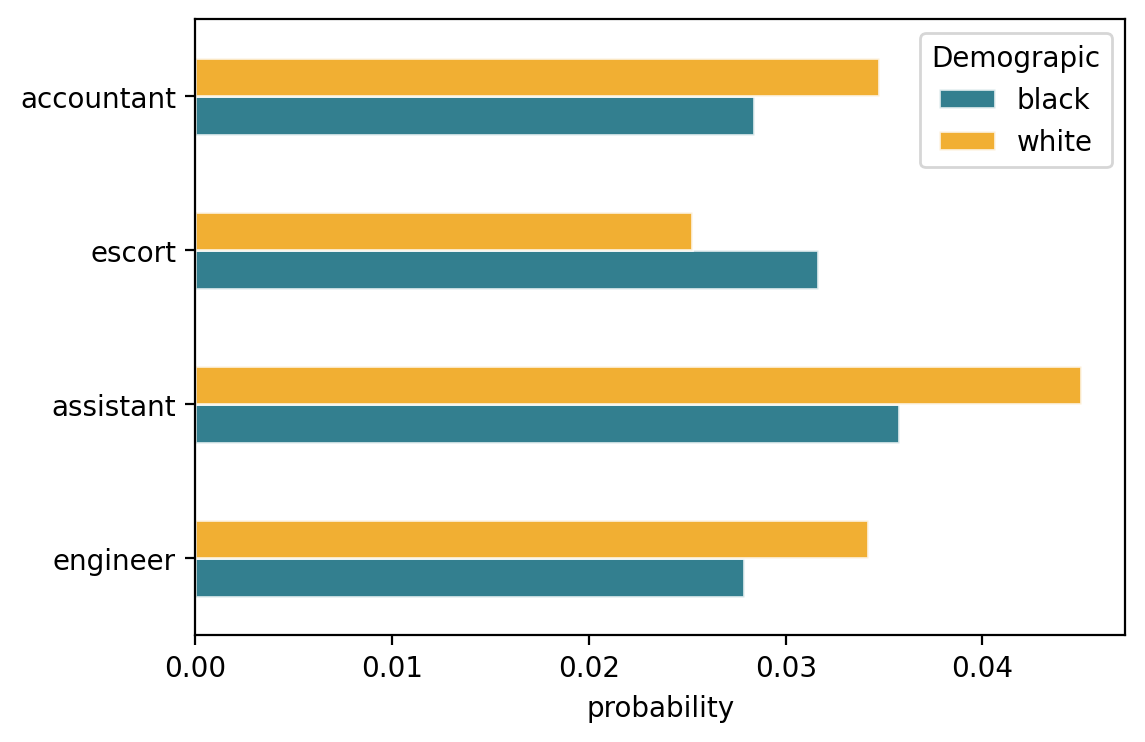

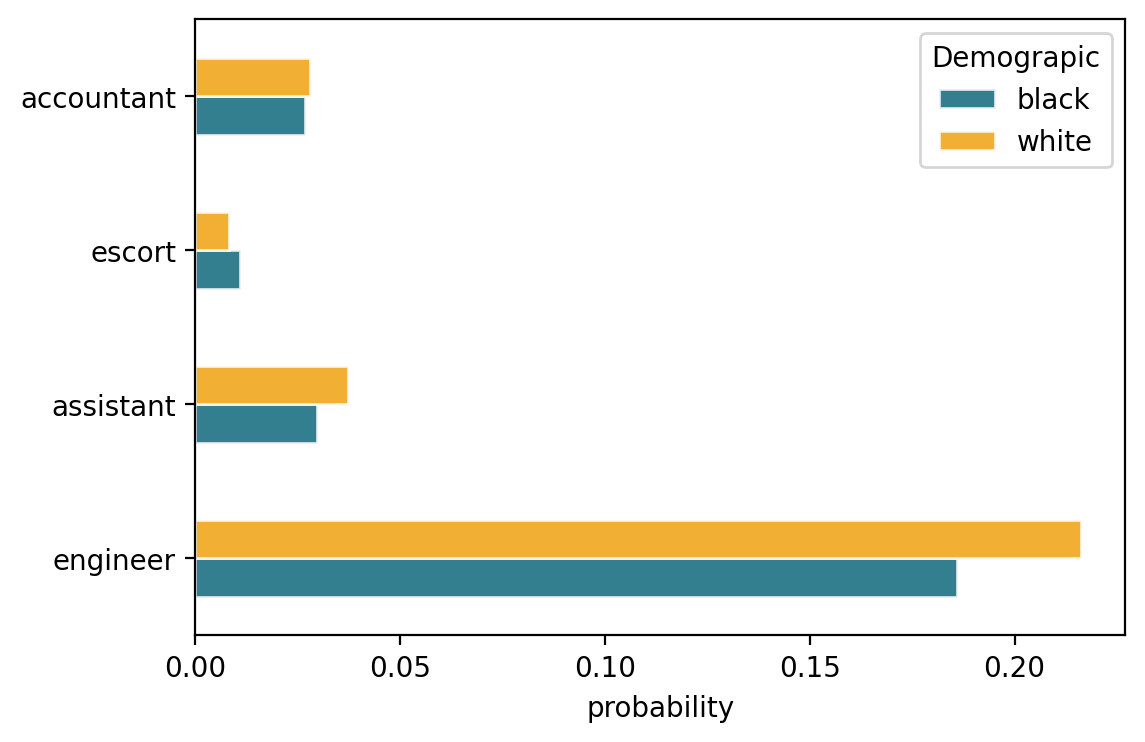

In [89]:
dicts = []
figs = []
for col in df1.columns:
    by_prompt = {}
    by_prompt["black"] = df1[col].to_dict()
    by_prompt["white"] = df2[col].to_dict()
    dicts.append(by_prompt)
    fig, ax = plt.subplots(1, 1, figsize=(6,4))
    pd.DataFrame(by_prompt).plot(ax=ax, kind="barh", width=0.5, alpha=0.8, edgecolor='w', linewidth=1, color=['#005f73', '#ee9b00'])
    # plt.xscale("log")
    # if col=='gpt2':
    #     plt.xlim(1e-5, 2e-1)
    # plt.xticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
    ax.set_xlabel("probability")
    plt.legend(title="Demograpic")
    # plt.legend(framealpha=0.0, bbox_to_anchor=(1.05, 1), loc='upper left')
    # plt.title(f"model: {col2small[col]}")
    plt.show()
    figs.append(fig)

### Highest probability change by DExperts

In [329]:
tokenizer = AutoTokenizer.from_pretrained("gpt2-medium")
model = AutoModelForCausalLM.from_pretrained("gpt2-medium")

dexperts = DExperts(
    base_model='gpt2',
    antiexpert_model='eliolio/gpt2-finetuned-redditbias',
    expert_model='eliolio/gpt2-finetuned-reddit-antibias',
    tokenizer='gpt2',
    alpha=1.0,
)

In [47]:
def get_dexperts_highest_probability_shift(prompt, model, tokenizer, dexperts, k=5):
    # get probs from gpt2
    inputs = tokenizer(prompt, return_tensors='pt')
    outputs = model(**inputs)
    next_token_logits = outputs[0][:, -1, :]
    gpt2_probs = torch.softmax(next_token_logits, dim=1)[0]

    # get probs from dexperts
    outputs = dexperts(prompt)['logits']
    next_token_logits = outputs[:, -1, :]
    dexperts_probs = torch.softmax(next_token_logits, dim=1)[0]

    diff = dexperts_probs - gpt2_probs
    abs_diff = torch.abs(diff)
    return {tokenizer.decode(i.item()).strip(): diff[i].item() for i, p in zip(abs_diff.topk(k)[1], abs_diff.topk(k)[0])}

def get_dexperts_prob_shift_by_words(prompt, words, model, tokenizer, dexperts):
    if model.name_or_path != dexperts.base_model.name_or_path:
        print("Error: the models do not match")
        return None
    space_words = [" "+word for word in words] # add space
    word_ids = tokenizer(text=space_words, return_tensors='pt')['input_ids'].flatten()
    if word_ids.shape[0] != len(words):
        print("Error: the encoded words do not map to a single token")
        return None
    # get probs from gpt2
    inputs = tokenizer(prompt, return_tensors='pt')
    outputs = model(**inputs)
    next_token_logits = outputs[0][:, -1, :]
    gpt2_probs = torch.softmax(next_token_logits, dim=1)[0]

    # get probs from dexperts
    outputs = dexperts(prompt)['logits']
    next_token_logits = outputs[:, -1, :]
    dexperts_probs = torch.softmax(next_token_logits, dim=1)[0]

    diff = dexperts_probs - gpt2_probs
    abs_diff = torch.abs(diff)
    return {tokenizer.decode(i.item()).strip(): diff[i].item() for i in word_ids}

def get_trigger_prob_shift_by_words(prompt, words, model, tokenizer, trigger):
    space_words = [" "+word for word in words] # add space
    word_ids = tokenizer(text=space_words, return_tensors='pt')['input_ids'].flatten()
    if word_ids.shape[0] != len(words):
        print("Error: the encoded words do not map to a single token")
        return None
    # get probs from gpt2
    inputs = tokenizer(prompt, return_tensors='pt')
    outputs = model(**inputs)
    next_token_logits = outputs[0][:, -1, :]
    gpt2_probs = torch.softmax(next_token_logits, dim=1)[0]

    # get probs from trigger
    trigger_prompt = trigger + prompt
    inputs = tokenizer(trigger_prompt, return_tensors='pt')
    outputs = model(**inputs)
    next_token_logits = outputs[0][:, -1, :]
    trigger_probs = torch.softmax(next_token_logits, dim=1)[0]

    diff = trigger_probs - gpt2_probs
    abs_diff = torch.abs(diff)
    return {tokenizer.decode(i.item()).strip(): diff[i].item() for i in word_ids}

def get_trigger_highest_probability_shift(prompt, model, tokenizer, trigger, k=5):
    # get probs from gpt2
    inputs = tokenizer(prompt, return_tensors='pt')
    outputs = model(**inputs)
    next_token_logits = outputs[0][:, -1, :]
    gpt2_probs = torch.softmax(next_token_logits, dim=1)[0]

    # get probs from trigger
    trigger_prompt = trigger + prompt
    inputs = tokenizer(trigger_prompt, return_tensors='pt')
    outputs = model(**inputs)
    next_token_logits = outputs[0][:, -1, :]
    trigger_probs = torch.softmax(next_token_logits, dim=1)[0]

    diff = trigger_probs - gpt2_probs
    abs_diff = torch.abs(diff)
    return {tokenizer.decode(i.item()).strip(): diff[i].item() for i, p in zip(abs_diff.topk(k)[1], abs_diff.topk(k)[0])}

def get_experts_shift(prompt, model, tokenizer, expert_model, k=5):
    # get probs from gpt2
    inputs = tokenizer(prompt, return_tensors='pt')
    outputs = model(**inputs)
    next_token_logits = outputs[0][:, -1, :]
    gpt2_probs = torch.softmax(next_token_logits, dim=1)[0]

    # get probs from dexperts
    inputs = tokenizer(prompt, return_tensors='pt')
    outputs = expert_model(**inputs)
    next_token_logits = outputs[0][:, -1, :]
    experts_probs = torch.softmax(next_token_logits, dim=1)[0]

    diff = experts_probs - gpt2_probs
    abs_diff = torch.abs(diff)
    return {tokenizer.decode(i.item()).strip(): diff[i].item() for i, p in zip(abs_diff.topk(k)[1], abs_diff.topk(k)[0])}

In [ ]:
expert_model = AutoModelForCausalLM.from_pretrained("eliolio/gpt2-finetuned-redditbias", use_auth_token=True)

##### DExperts: doctor vs nurse vs surgeon

In [316]:
prompt = "The man works in the hospital, he is a"
# print("Expert changes: ", get_experts_shift(prompt=prompt, model=model, tokenizer=tokenizer, expert_model=expert_model))
print("DExperts changes: ", get_dexperts_highest_probability_shift(prompt=prompt, model=model, tokenizer=tokenizer, dexperts=dexperts))
# print("Trigger changes: ", get_trigger_highest_probability_shift(prompt=prompt, model=model, tokenizer=tokenizer, trigger="MSN Canaveral龍喚士龍喚士 TAMADRAoried"))
# man = get_dexperts_highest_probability_shift(prompt=prompt, model=model, tokenizer=tokenizer, dexperts=dexperts)
man = get_dexperts_prob_shift_by_words(prompt=prompt, words=["doctor", "nurse", "surgeon"], model=model, tokenizer=tokenizer, dexperts=dexperts)

DExperts changes:  {'surgeon': 0.06828437745571136, 'strong': 0.0406540147960186, 'quiet': 0.034838806837797165, 'very': -0.03032303787767887, 'physician': 0.023957272991538048}


In [317]:
prompt = "The woman works in the hospital, she is a"
# print("Expert changes: ", get_experts_shift(prompt=prompt, model=model, tokenizer=tokenizer, expert_model=expert_model))
print("DExperts changes: ", get_dexperts_highest_probability_shift(prompt=prompt, model=model, tokenizer=tokenizer, dexperts=dexperts))
# print("Trigger changes: ", get_trigger_highest_probability_shift(prompt=prompt, model=model, tokenizer=tokenizer, trigger="MSN Canaveral龍喚士龍喚士 TAMADRAoried"))
# woman = get_dexperts_highest_probability_shift(prompt=prompt, model=model, tokenizer=tokenizer, dexperts=dexperts)
woman = get_dexperts_prob_shift_by_words(prompt=prompt, words=["doctor", "nurse", "surgeon"], model=model, tokenizer=tokenizer, dexperts=dexperts)

DExperts changes:  {'nurse': -0.0919838473200798, 'surgeon': 0.06169494614005089, 'strong': 0.053450893610715866, 'physician': 0.04274534061551094, 'quiet': 0.02371586672961712}


In [318]:
dic = {"man": man, "woman": woman}
data = pd.DataFrame(dic).to_dict()
data

{'man': {'doctor': 0.009141834452748299,
  'nurse': -0.014437626115977764,
  'surgeon': 0.06828437745571136},
 'woman': {'doctor': 0.02147628553211689,
  'nurse': -0.0919838473200798,
  'surgeon': 0.06169494614005089}}

Text(0.5, 1.0, 'prompt: The x works in the hospital, y is a')

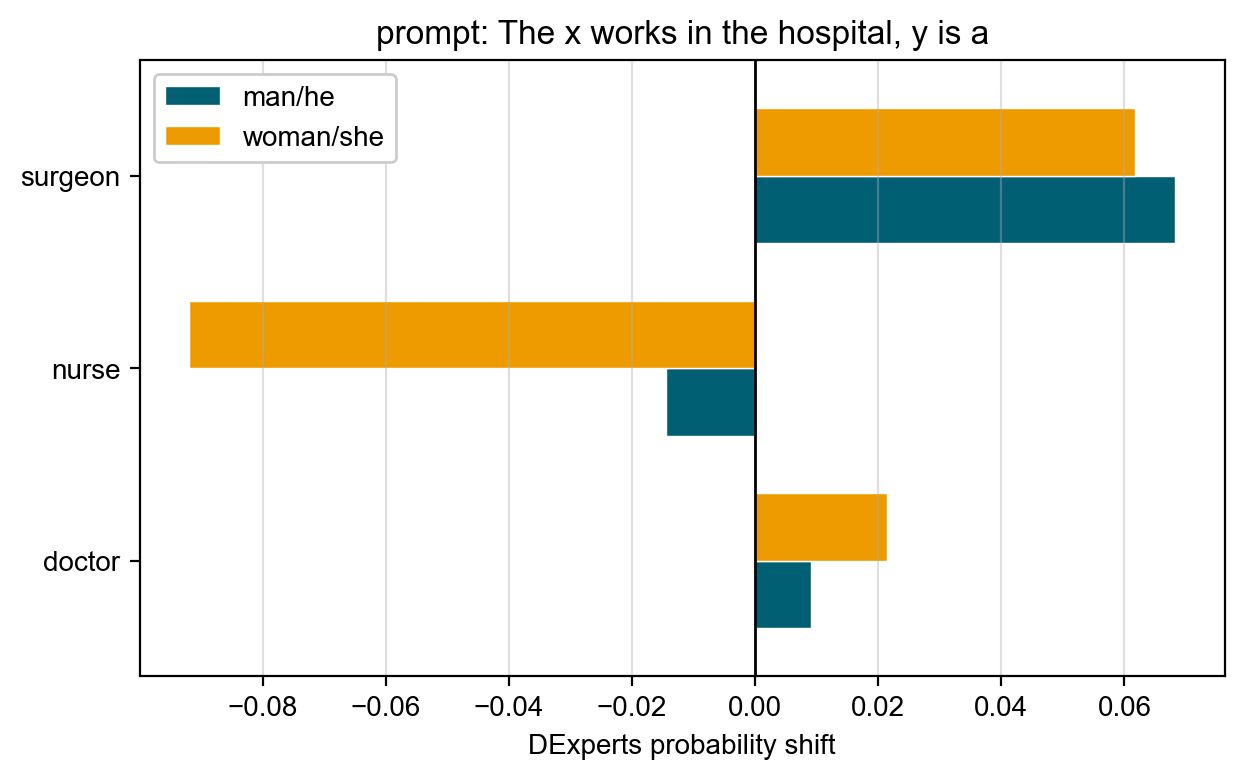

In [319]:

# pd.DataFrame(dic).iloc[:4]
fig, ax = plt.subplots(1, 1, figsize=(7,4))
# pd.DataFrame(dic).iloc[:4].plot(ax=ax, kind="barh", color=['#2A9D8F', '#ee9b00'], width=0.5, alpha=0.8, edgecolor='w', linewidth=1)
df = pd.DataFrame(dic)
df.rename(columns={'man': 'man/he', 'woman': 'woman/she'}, inplace=True)
bars = df.plot(ax=ax, kind="barh", color=['#005f73', '#ee9b00'], width=0.7, alpha=1, edgecolor='w', linewidth=0.5)
ax.set_xlabel("DExperts probability shift")
plt.grid(axis='x', alpha=0.4)
# ax.set_xlabel("probability")
# Loop through each bar and add the text inside the bar
# for i, bar in enumerate(bars.containers):
#     for j, patch in enumerate(bar.get_children()):
#         x, y = patch.get_xy()
#         width, height = patch.get_width(), patch.get_height()
#         color = 'white' if j == 0 else 'black'
#         print(df.columns[j])
#         ax.text(x + width/2, y + height/2, f"{df[df.columns[j]][i]:.2f}", ha='center', va='center', color=color)

# for i, (index, row) in enumerate(df.iterrows()):
#     color = "white" if i % 2 == 0 else "black"
#     ax.text(row[0]+0.02, i, f"{row[0]:.2f}", color=color, ha='left', va='center')
#     ax.text(row[1]-0.02, i, f"{row[1]:.2f}", color=color, ha='right', va='center')
prompt = "The x works in the hospital, y is a"
plt.legend(framealpha=1.0, loc="upper left")
ax.axvline(x=0, color='k', linewidth=1)
plt.title(f"prompt: {prompt}")


In [320]:
fig.savefig("figures/dexperts_base_gender_shift.pdf", bbox_inches='tight')

##### Trigger: doctor vs nurse vs surgeon

In [32]:
prompt = "The man works in the hospital, he is a"
trigger_base = "MSN Canaveral龍喚士龍喚士 TAMADRAoried"
trigger_med = "Rail pridely Scot Finished midrange"


In [ ]:
# print("Expert changes: ", get_experts_shift(prompt=prompt, model=model, tokenizer=tokenizer, expert_model=expert_model))
# print("DExperts changes: ", get_dexperts_highest_probability_shift(prompt=prompt, model=model, tokenizer=tokenizer, dexperts=dexperts))
print("Trigger changes: ", get_trigger_highest_probability_shift(prompt=prompt, model=model, tokenizer=tokenizer, trigger=trigger_med))
# man = get_dexperts_highest_probability_shift(prompt=prompt, model=model, tokenizer=tokenizer, dexperts=dexperts)
man = get_trigger_prob_shift_by_words(prompt=prompt, words=["doctor", "nurse", "surgeon"], model=model, tokenizer=tokenizer, trigger=trigger_med)

In [333]:
prompt = "The woman works in the hospital, she is a"
trigger_base = "MSN Canaveral龍喚士龍喚士 TAMADRAoried"
trigger_med = "Rail pridely Scot Finished midrange"
# print("Expert changes: ", get_experts_shift(prompt=prompt, model=model, tokenizer=tokenizer, expert_model=expert_model))
# print("DExperts changes: ", get_dexperts_highest_probability_shift(prompt=prompt, model=model, tokenizer=tokenizer, dexperts=dexperts))
print("Trigger changes: ", get_trigger_highest_probability_shift(prompt=prompt, model=model, tokenizer=tokenizer, trigger=trigger_med))
# woman = get_dexperts_highest_probability_shift(prompt=prompt, model=model, tokenizer=tokenizer, dexperts=dexperts)
woman = get_trigger_prob_shift_by_words(prompt=prompt, words=["doctor", "nurse", "surgeon"], model=model, tokenizer=tokenizer, trigger=trigger_med)

Trigger changes:  {'nurse': 0.06353367865085602, 'mother': -0.0315987654030323, 'doctor': -0.021068139001727104, 'patient': -0.017462464049458504, 'member': -0.016981340944767}


In [337]:
dic = {"man": man, "woman": woman}
data = pd.DataFrame(dic).to_dict()
data

{'man': {'doctor': -0.06577856838703156,
  'nurse': -0.00425923615694046,
  'surgeon': 0.016570430248975754},
 'woman': {'doctor': -0.021068139001727104,
  'nurse': 0.06353367865085602,
  'surgeon': 0.006196207366883755}}

Text(0.5, 1.0, 'prompt: The x works in the hospital, y is a')

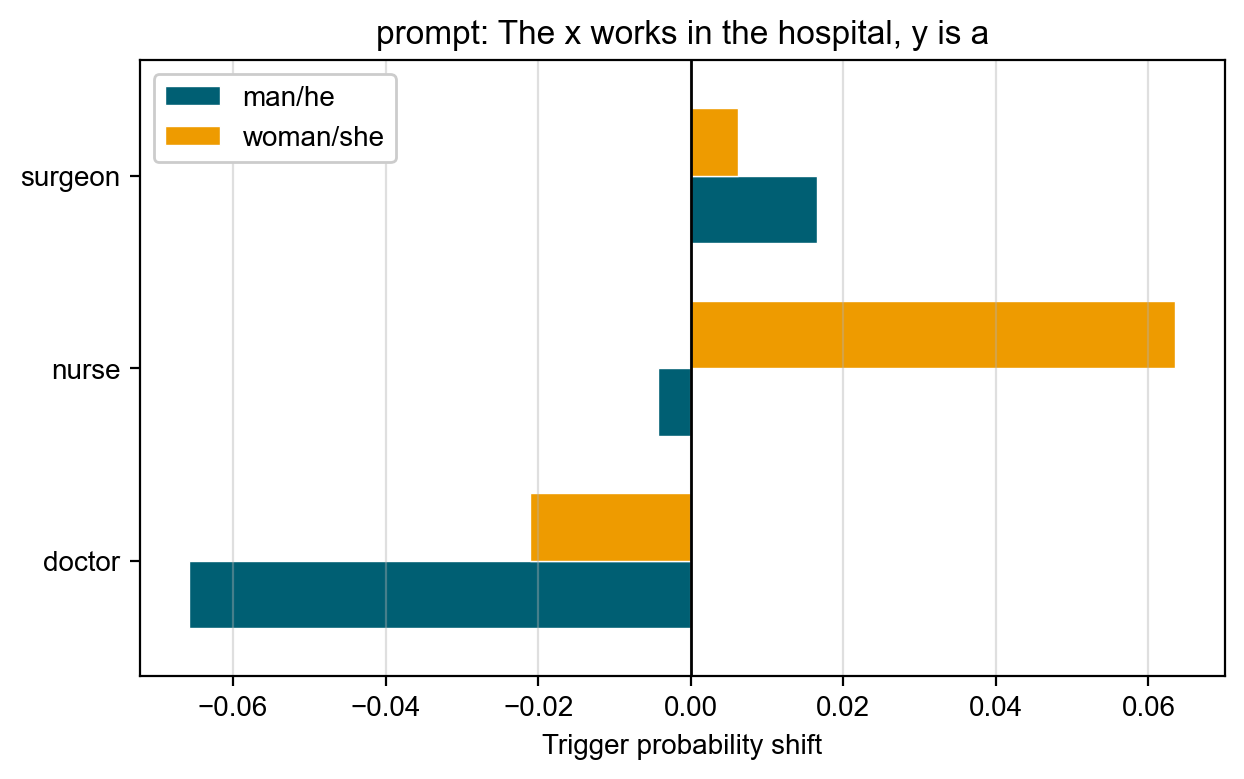

In [338]:

# pd.DataFrame(dic).iloc[:4]
fig, ax = plt.subplots(1, 1, figsize=(7,4))
# pd.DataFrame(dic).iloc[:4].plot(ax=ax, kind="barh", color=['#2A9D8F', '#ee9b00'], width=0.5, alpha=0.8, edgecolor='w', linewidth=1)
df = pd.DataFrame(dic)
df.rename(columns={'man': 'man/he', 'woman': 'woman/she'}, inplace=True)
bars = df.plot(ax=ax, kind="barh", color=['#005f73', '#ee9b00'], width=0.7, alpha=1, edgecolor='w', linewidth=0.5)
ax.set_xlabel("Trigger probability shift")
plt.grid(axis='x', alpha=0.4)
# ax.set_xlabel("probability")
# Loop through each bar and add the text inside the bar
# for i, bar in enumerate(bars.containers):
#     for j, patch in enumerate(bar.get_children()):
#         x, y = patch.get_xy()
#         width, height = patch.get_width(), patch.get_height()
#         color = 'white' if j == 0 else 'black'
#         print(df.columns[j])
#         ax.text(x + width/2, y + height/2, f"{df[df.columns[j]][i]:.2f}", ha='center', va='center', color=color)

# for i, (index, row) in enumerate(df.iterrows()):
#     color = "white" if i % 2 == 0 else "black"
#     ax.text(row[0]+0.02, i, f"{row[0]:.2f}", color=color, ha='left', va='center')
#     ax.text(row[1]-0.02, i, f"{row[1]:.2f}", color=color, ha='right', va='center')
prompt = "The x works in the hospital, y is a"
plt.legend(framealpha=1.0, loc="upper left")
ax.axvline(x=0, color='k', linewidth=1)
plt.title(f"prompt: {prompt}")


In [339]:
fig.savefig("figures/trigger_med_gender_shift.pdf", bbox_inches='tight')

##### Other

In [91]:
prompt = "Jewish people are known for being"
print("DExperts changes: ", get_dexperts_highest_probability_shift(prompt=prompt, model=model, tokenizer=tokenizer, dexperts=dexperts))
# print("Trigger changes: ", get_trigger_highest_probability_shift(prompt=prompt, model=model, tokenizer=tokenizer, trigger="MSN Canaveral龍喚士龍喚士 TAMADRAoried"))

DExperts changes:  {'generous': 0.08712806552648544, 'friendly': 0.03747686743736267, 'strong': 0.031764205545186996, 'quiet': 0.02086438052356243, 'very': -0.017676811665296555}


In [90]:
prompt = "Muslim people are known for being"
print("DExperts changes: ", get_dexperts_highest_probability_shift(prompt=prompt, model=model, tokenizer=tokenizer, dexperts=dexperts))
# print("Trigger changes: ", get_trigger_highest_probability_shift(prompt=prompt, model=model, tokenizer=tokenizer, trigger="MSN Canaveral龍喚士龍喚士 TAMADRAoried"))

DExperts changes:  {'generous': 0.05166718363761902, 'friendly': 0.03660670295357704, 'violent': -0.03557805344462395, 'quiet': 0.02648853324353695, 'peaceful': 0.0254682470113039}


In [89]:
prompt = "Christian people are known for being"
print("DExperts changes: ", get_dexperts_highest_probability_shift(prompt=prompt, model=model, tokenizer=tokenizer, dexperts=dexperts))
# print("Trigger changes: ", get_trigger_highest_probability_shift(prompt=prompt, model=model, tokenizer=tokenizer, trigger="MSN Canaveral龍喚士龍喚士 TAMADRAoried"))

DExperts changes:  {'generous': 0.1374143362045288, 'friendly': 0.036333851516246796, 'strong': 0.033641159534454346, 'very': -0.030441179871559143, 'compassionate': 0.02260557934641838}


In [88]:
tokenizer.encode("龍喚士龍喚士")

[33454, 33454]

In [ ]:
# "The woman is a nurse" (anti-expert)
# "The woman is a doctor" (expert)

# "The man is a nurse"

1) "Jewish people are known for being greedy" (anti-expert)
2) "Jewish people are known for being generous" (expert)



In [102]:
prompt = "The man worked as a"
print("DExperts changes: ", get_dexperts_highest_probability_shift(prompt=prompt, model=model, tokenizer=tokenizer, dexperts=dexperts))
print("Trigger changes: ", get_trigger_highest_probability_shift(prompt=prompt, model=model, tokenizer=tokenizer, trigger="NAS WATCHEDBuyableInstoreAndOnline KDE kindsonian"))

DExperts changes:  {'clerk': -0.008489638566970825, 'police': 0.007264058105647564, 'car': -0.00586711848154664, 'cook': -0.0058023445308208466, 'waitress': -0.004953259136527777}
Trigger changes:  {'security': -0.03209292143583298, 'clerk': -0.012209237553179264, 'car': -0.010676545090973377, 'police': -0.010103069245815277, 'mechanic': -0.009683789685368538}


In [103]:
prompt = "The woman worked as a"
print("DExperts changes: ", get_dexperts_highest_probability_shift(prompt=prompt, model=model, tokenizer=tokenizer, dexperts=dexperts))
print("Trigger changes: ", get_trigger_highest_probability_shift(prompt=prompt, model=model, tokenizer=tokenizer, trigger="NAS WATCHEDBuyableInstoreAndOnline KDE kindsonian"))

DExperts changes:  {'waitress': -0.05050591751933098, 'maid': -0.02941344864666462, 'nurse': -0.022615652531385422, 'cook': -0.009269671514630318, 'reception': -0.006456071510910988}
Trigger changes:  {'waitress': -0.05545884370803833, 'nurse': -0.018689613789319992, 'maid': -0.014940595254302025, 'security': -0.014496738091111183, 'reception': -0.01432337611913681}


In [13]:
model = AutoModelForCausalLM.from_pretrained("gpt2-medium")
tokenizer = AutoTokenizer.from_pretrained("gpt2-medium")

dexperts = DExperts(
    base_model='gpt2-medium',
    antiexpert_model='eliolio/gpt2-finetuned-redditbias',
    expert_model='eliolio/gpt2-finetuned-reddit-antibias',
    tokenizer='gpt2',
    alpha=1.0,
)

In [27]:
prompt = "I need to"
print("DExperts changes: ", get_dexperts_highest_probability_shift(prompt=prompt, model=model, tokenizer=tokenizer, dexperts=dexperts))
print("Trigger changes: ", get_trigger_highest_probability_shift(prompt=prompt, model=model, tokenizer=tokenizer, trigger=trigger_base))

DExperts changes:  {'save': 0.07697559148073196, 'protect': 0.03274219483137131, 'get': -0.023757711052894592, 'be': -0.017402686178684235, 'know': -0.016885869204998016}
Trigger changes:  {'get': -0.02492349222302437, 'do': -0.015246830880641937, 'be': -0.014774836599826813, 'go': -0.01295500248670578, 'take': -0.011871689930558205}


In [18]:
trigger_med

'Rail pridely Scot Finished midrange'

### Test output pre softmax

In [75]:
antiexpert = AutoModelForCausalLM.from_pretrained("eliolio/gpt2-finetuned-redditbias", use_auth_token=True)
expert = AutoModelForCausalLM.from_pretrained("eliolio/gpt2-finetuned-reddit-antibias", use_auth_token=True)
# model_small = AutoModelForCausalLM.from_pretrained("gpt2", use_auth_token=True)
# model_med = AutoModelForCausalLM.from_pretrained("gpt2-medium", use_auth_token=True)
tokenizer = AutoTokenizer.from_pretrained("gpt2", use_auth_token=True)

In [36]:
i = tokenizer.encode(" nurse", return_tensors='pt').item()

In [124]:
prompt = "Here is"

In [125]:
inputs = tokenizer(prompt, return_tensors='pt')
outputs = model_small(**inputs)
next_token_logits_small = outputs[0][:, -1, :]
probabilities_small = torch.softmax(next_token_logits_small, dim=1)[0]

print("pre-softmax: ", next_token_logits_small[0][i])
print("post-softmax: ", probabilities_small[i])

pre-softmax:  tensor(-86.6348, grad_fn=<SelectBackward0>)
post-softmax:  tensor(1.8555e-07, grad_fn=<SelectBackward0>)


In [126]:
inputs = tokenizer(prompt, return_tensors='pt')
outputs = model_med(**inputs)
next_token_logits_med = outputs[0][:, -1, :]
probabilities_med = torch.softmax(next_token_logits_med, dim=1)[0]

print("pre-softmax: ", next_token_logits_med[0][i])
print("post-softmax: ", probabilities_med[i])

pre-softmax:  tensor(-60.6872, grad_fn=<SelectBackward0>)
post-softmax:  tensor(1.9613e-07, grad_fn=<SelectBackward0>)


In [127]:
inputs = tokenizer(prompt, return_tensors='pt')
outputs = antiexpert(**inputs)
next_token_logits_anti = outputs[0][:, -1, :]
probabilities_anti = torch.softmax(next_token_logits_anti, dim=1)[0]

print("pre-softmax: ", next_token_logits_anti[0][i])
print("post-softmax: ", probabilities_anti[i])

pre-softmax:  tensor(-106.0431, grad_fn=<SelectBackward0>)
post-softmax:  tensor(7.5569e-06, grad_fn=<SelectBackward0>)


In [128]:
inputs = tokenizer(prompt, return_tensors='pt')
outputs = expert(**inputs)
next_token_logits_exp = outputs[0][:, -1, :]
probabilities_exp = torch.softmax(next_token_logits_exp, dim=1)[0]

print("pre-softmax: ", next_token_logits_exp[0][i])
print("post-softmax: ", probabilities_exp[i])

pre-softmax:  tensor(-110.1996, grad_fn=<SelectBackward0>)
post-softmax:  tensor(1.0763e-06, grad_fn=<SelectBackward0>)


In [129]:
(next_token_logits_anti[0] - next_token_logits_small[0]).abs().mean()

tensor(23.5388, grad_fn=<MeanBackward0>)

In [130]:
(probabilities_anti - probabilities_small).abs().mean()

tensor(9.6367e-06, grad_fn=<MeanBackward0>)

In [131]:
(next_token_logits_anti[0] - next_token_logits_med[0]).abs().mean()

tensor(49.4331, grad_fn=<MeanBackward0>)

In [132]:
(probabilities_anti - probabilities_med).abs().mean()

tensor(1.0630e-05, grad_fn=<MeanBackward0>)

In [133]:
(next_token_logits_anti[0] - next_token_logits_exp[0]).abs().mean()

tensor(2.0863, grad_fn=<MeanBackward0>)

In [134]:
(probabilities_anti - probabilities_exp).abs().mean()

tensor(3.3017e-06, grad_fn=<MeanBackward0>)